<a href="https://colab.research.google.com/github/AbhishekPandey91/Agentic_Chatbot/blob/main/Robotics_LSTM_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
link = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import math


In [ ]:
# SEQ_LEN = 12 → model looks at 12 previous months to predict the next month.

# TEST_RATIO = 0.2 → 20% of data used for testing (model evaluation).

# EPOCHS = 100 → training will repeat up to 100 passes over data.

# BATCH_SIZE = 16 → 16 samples are processed before updating weights.

# PATIENCE = 10 → if validation loss doesn’t improve for 10 epochs, stop training.

# # FUTURE_STEPS = 12 → forecast 12 future months beyond dataset.

In [30]:

DATE_COL = "Month"               # Name of date column
VALUE_COL = "Passengers"         # Name of target column
SEQ_LEN = 12                     # Number of past months to use
TEST_RATIO = 0.2                 # 20% test data
RANDOM_SEED = 42                 # Seed for reproducibility
EPOCHS = 100                     # Max training iterations
BATCH_SIZE = 16                  # How many samples per gradient update
PATIENCE = 10                    # Early stopping patience
FUTURE_STEPS = 12                # Forecast next 12 months


In [32]:
df = pd.read_csv(link)
df[DATE_COL] = pd.to_datetime(df[DATE_COL], format="%Y-%m")
df = df.sort_values(by=DATE_COL).reset_index(drop=True)


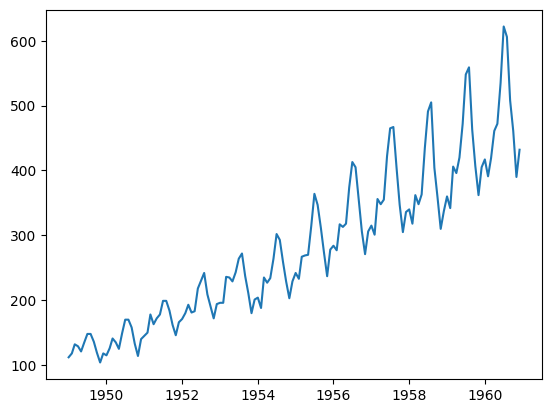

In [33]:
plt.plot(df['Month'],df['Passengers'])

In [34]:
data = df[[DATE_COL, VALUE_COL]].copy()
data.set_index(DATE_COL, inplace=True)


In [35]:
scaler = MinMaxScaler(feature_range=(0, 1))
values = data[[VALUE_COL]].values.astype("float32")
scaled = scaler.fit_transform(values)


In [ ]:
# For time series, you don’t feed a single value → you feed a sequence of past values.

# Example with SEQ_LEN=12:

# X = [Jan–Dec 1949], y = Jan 1950.

# X = [Feb 1949 – Jan 1950], y = Feb 1950.

# This turns a 1D series into supervised learning samples.

In [36]:
def create_sequences(series, seq_len):
    X, y = [], []
    for i in range(len(series) - seq_len):
        X.append(series[i:i+seq_len])
        y.append(series[i+seq_len])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled, SEQ_LEN)


In [37]:
n_samples = X.shape[0]
test_size = int(n_samples * TEST_RATIO)
train_size = n_samples - test_size

X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]


In [ ]:
# Sequential() → build model layer-by-layer.

# Bidirectional(LSTM(64, return_sequences=True)) →

# 64 units → memory cells (higher = more capacity).

# return_sequences=True → keep full sequence output (needed if stacking).

# Bidirectional → processes sequence forward + backward (captures more context).

# Dropout(0.2) → randomly disables 20% of neurons to reduce overfitting.

# Bidirectional(LSTM(32)) → second BiLSTM layer with 32 units.

# Dense(16, activation="relu") → fully connected layer with ReLU nonlinearity.

# Dense(1) → final output neuron = next month’s passenger count (scaled).

# compile(optimizer="adam", loss="mse") →

# adam → adaptive learning rate optimizer (good default).

# mse (Mean Squared Error) → typical loss for regression tasks

In [48]:
def build_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation="relu"))
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mse")
    return model


In [ ]:
# EarlyStopping → stops training if validation loss doesn’t improve for PATIENCE epochs.

# restore_best_weights=True → keeps the best model found during training.

# validation_data=(X_test, y_test) → monitor test performance each epoch.

# batch_size=16 → updates weights after 16 samples.

# verbose=2 → prints training progress cleanly.

In [49]:
es = EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es],
    verbose=2
)


Epoch 1/100
7/7 - 0s - 34ms/step - loss: 0.0017 - val_loss: 0.0066
Epoch 2/100
7/7 - 0s - 37ms/step - loss: 0.0016 - val_loss: 0.0051
Epoch 3/100
7/7 - 0s - 42ms/step - loss: 0.0014 - val_loss: 0.0039
Epoch 4/100
7/7 - 0s - 45ms/step - loss: 0.0016 - val_loss: 0.0046
Epoch 5/100
7/7 - 0s - 41ms/step - loss: 0.0016 - val_loss: 0.0071
Epoch 6/100
7/7 - 0s - 29ms/step - loss: 0.0014 - val_loss: 0.0091
Epoch 7/100
7/7 - 0s - 42ms/step - loss: 0.0015 - val_loss: 0.0047
Epoch 8/100
7/7 - 0s - 43ms/step - loss: 0.0013 - val_loss: 0.0075
Epoch 9/100
7/7 - 0s - 33ms/step - loss: 0.0015 - val_loss: 0.0059
Epoch 10/100
7/7 - 0s - 46ms/step - loss: 0.0015 - val_loss: 0.0117
Epoch 11/100
7/7 - 0s - 52ms/step - loss: 0.0016 - val_loss: 0.0063
Epoch 12/100
7/7 - 0s - 49ms/step - loss: 0.0014 - val_loss: 0.0046
Epoch 13/100
7/7 - 1s - 92ms/step - loss: 0.0016 - val_loss: 0.0038
Epoch 14/100
7/7 - 1s - 71ms/step - loss: 0.0012 - val_loss: 0.0067
Epoch 15/100
7/7 - 0s - 43ms/step - loss: 0.0016 - val_lo

In [ ]:
# predict → model outputs scaled values (0–1).

# inverse_transform → convert back to original passenger counts.

In [50]:
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


In [51]:
rmse = math.sqrt(mean_squared_error(y_true, y_pred))
print(f"Test RMSE: {rmse:.3f}")


Test RMSE: 28.018


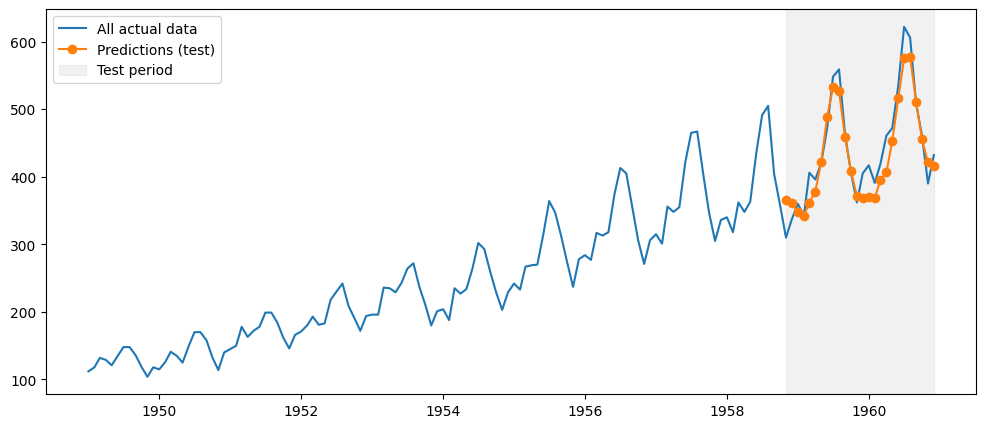

In [52]:
plt.figure(figsize=(12,5))
plt.plot(data.index, data[VALUE_COL], label="All actual data")
plt.plot(dates, y_pred.flatten(), label="Predictions (test)", marker="o")
plt.axvspan(dates[0], dates[-1], color="lightgrey", alpha=0.3, label="Test period")
plt.legend()
plt.show()


In [53]:
def forecast_future(model, last_sequence, steps, scaler):
    seq = last_sequence.copy()
    preds = []
    for _ in range(steps):
        x_in = seq.reshape((1, seq.shape[0], 1))
        yhat_scaled = model.predict(x_in)
        yhat = scaler.inverse_transform(yhat_scaled)[0,0]
        preds.append(yhat)
        seq = np.vstack([seq[1:], yhat_scaled.reshape(1,1)])
    return preds


In [ ]:
# Uses recursive forecasting:

# Take last known 12 months.

# Predict next month.

# Append prediction to sequence.

# Repeat for multiple steps ahead.

In [54]:
model.save("bilstm_model.h5")


In [55]:
future_df = pd.DataFrame({"Month": future_dates, "Forecast_Passengers": future_preds})
print(future_df)


        Month  Forecast_Passengers
0  1961-01-01           403.666595
1  1961-02-01           387.461609
2  1961-03-01           407.583984
3  1961-04-01           441.344391
4  1961-05-01           485.743683
5  1961-06-01           560.675842
6  1961-07-01           627.639954
7  1961-08-01           626.688232
8  1961-09-01           570.769043
9  1961-10-01           518.511780
10 1961-11-01           463.487671
11 1961-12-01           444.154480


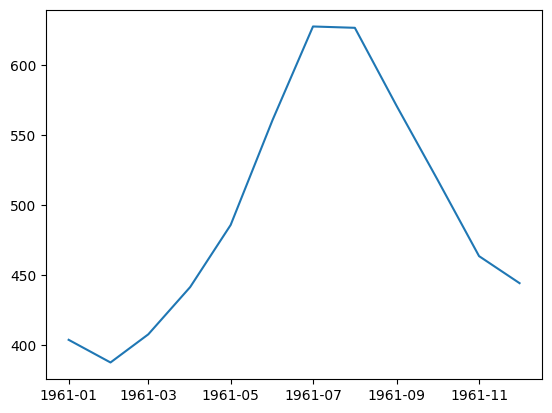

In [56]:
plt.plot(future_dates,future_preds)